In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score,mean_absolute_error

## Read data from file

In [3]:
data = pd.read_csv('rent_data_ready_for_ml.csv', index_col=0)

## Pre-process the data

The data is already processed after our previous phase. However, there are things we can do to improve the training process with this data, is to reduce the magnitute of the price number. For now, they are all number of over 6 digits, which could make the calculation process slower. Let's try to reduce that by changing the metric from `vnd` to `million vnd`. 

In [4]:
data['Price'] = data['Price'] / 1000000
data.rename({'Price': 'Price (million vnd)'}, inplace=True)

We also need to do is to remove the `Post data` column as we won't be using that for trainint.

In [5]:
data.drop(['Post date'], axis=1, inplace=True)

The data is now ready for training. For our model, we'll be focusing on predicting the price of `Căn hộ chung cư` property. 

In [6]:
data = data[data['Rent type'] == 'Căn hộ chung cư']

#### Detect outliner in the data

c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

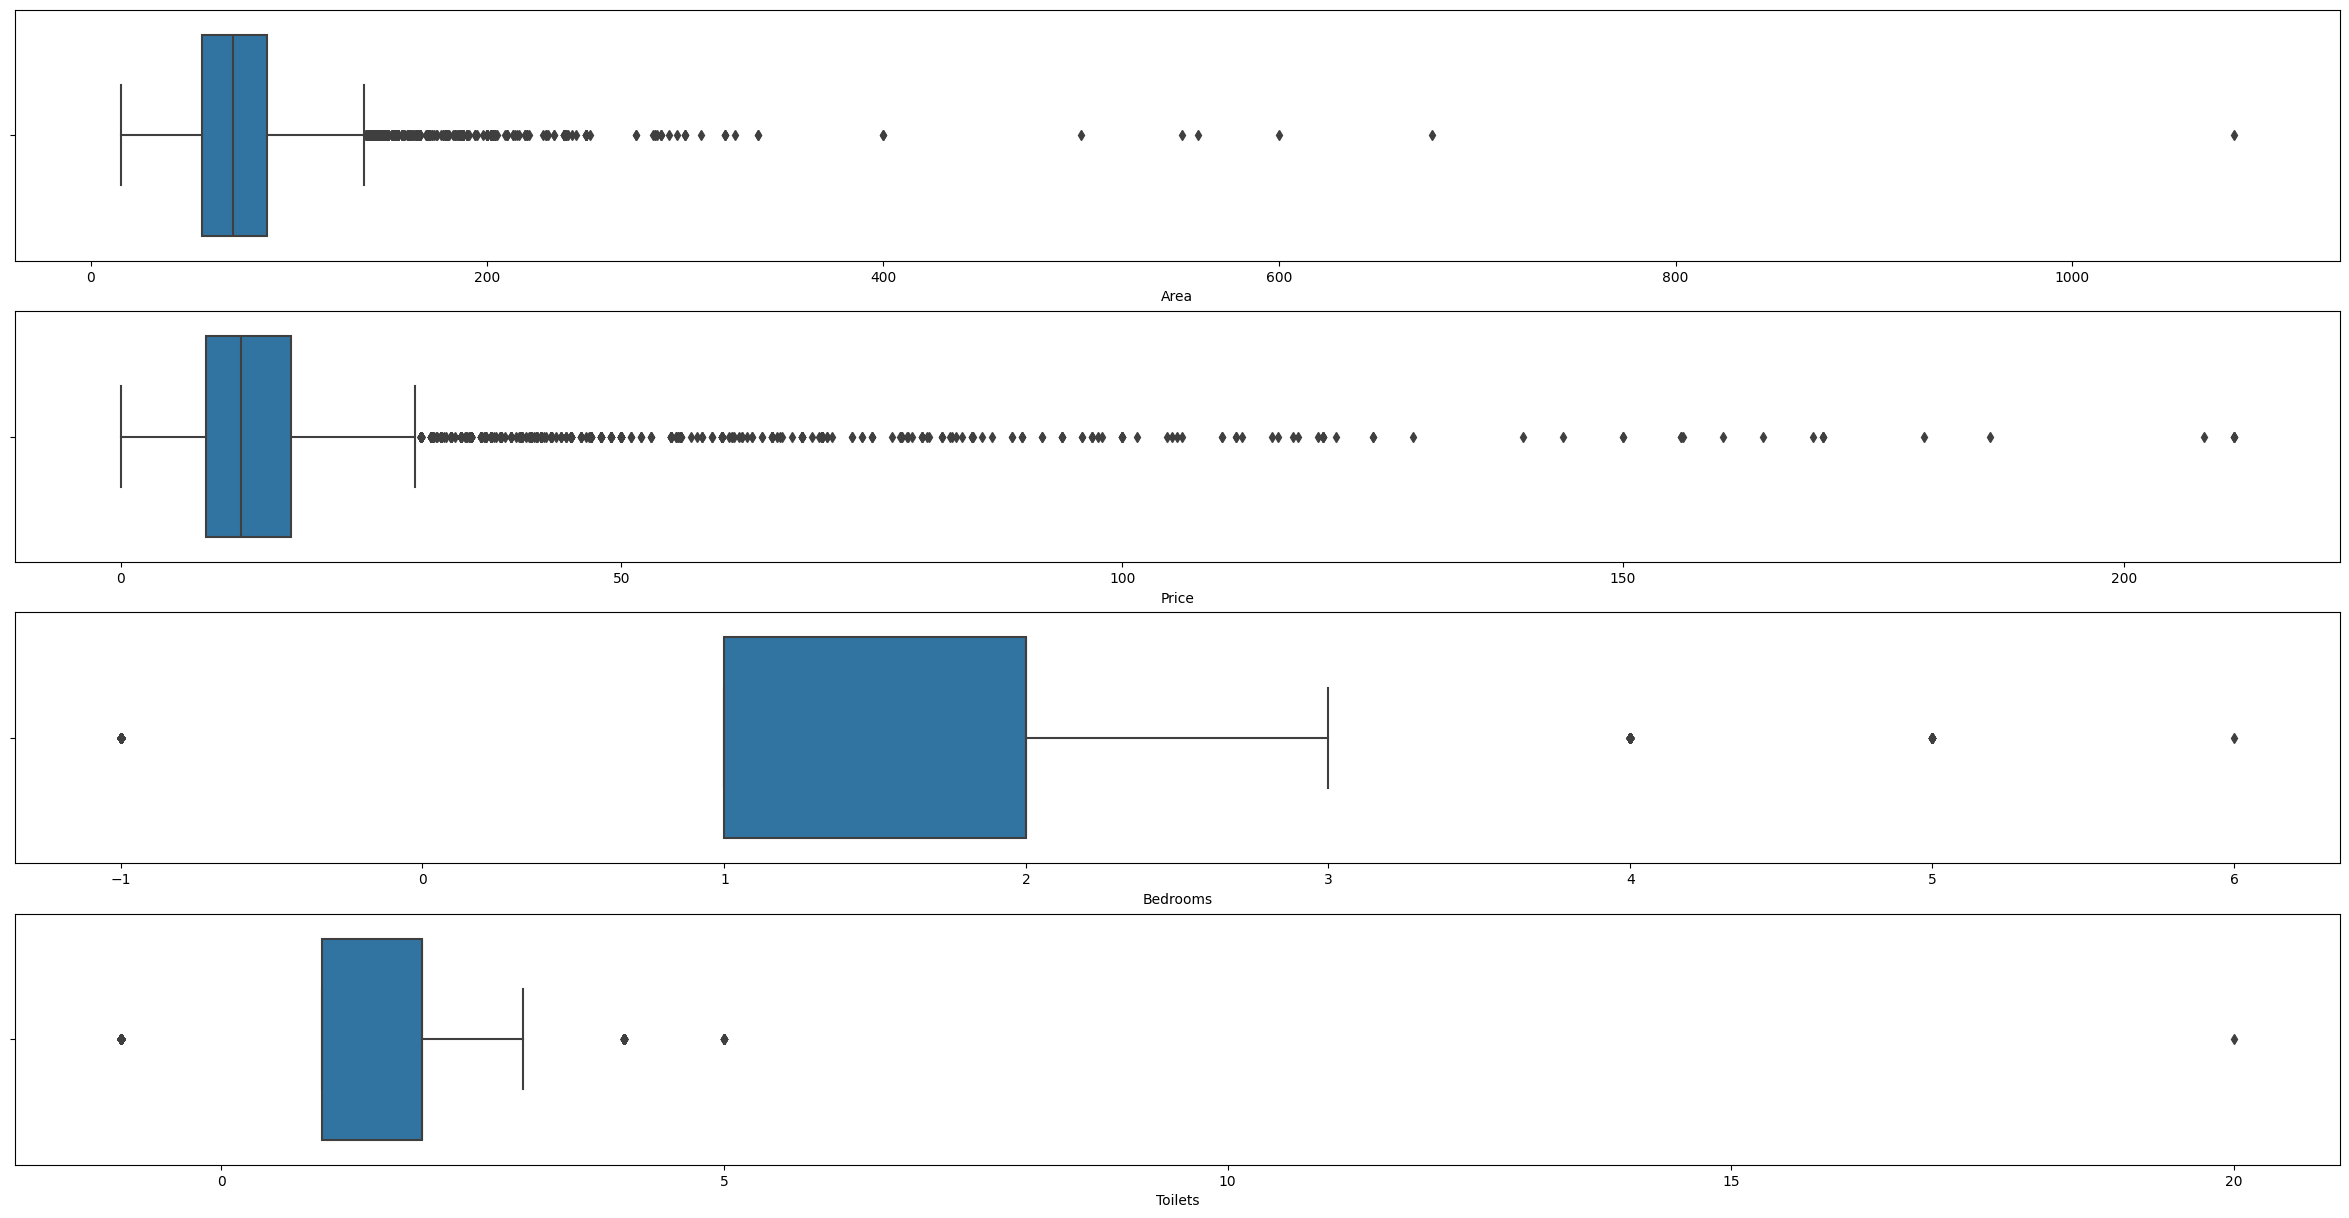

In [7]:
columns_to_plot = ['Area', 'Price', 'Bedrooms', 'Toilets']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 15))

for i, column in enumerate(columns_to_plot):
    sns.boxplot(x = data[column], ax=axes[i])

As we can see, there is a lot of outliner in all of the fields. 

Let's assume that the outliner are valid and not due to insertion error in the dataset. I'll keep the data as is becuase I believe the outliner is relevance in our training. 

#### Model selection

There are flavors to model selection:
1. Using `cross_val_score`: This method allows us to measure the accuracy of a models on multiple datasets to determine the best score. 
2. Using `GridSearchCV`: This method allows us to tune hyperparameters of a model while feeding k-fold datasets to determine the best hyperparameter for the model.

In practice, we can use both to do model selection. But a more realist setting, Data Scientist would most likely use `GridSearchCV` to model select and tune at the same time. But our project is focus on the education and exploratory aspects of Data Science, therefore I'd like to take the simpler approach to fully understand the basic first, before moving onto more advance method. In addition, using only `cross_val_score` will focus us entirely on model selection and it would save a lot more time compare to the `GridSearchCV` approach.

In [69]:
# Prepare predictors and response variable
## TODO: Re tweek this please
x = data.loc[:, ['Area', 'Bedrooms', 'Toilets','Floors', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9',
       'bình chánh', 'bình thạnh', 'bình tân', 'củ chi', 'gò vấp', 'hóc môn',
       'nhà bè', 'phú nhuận', 'thủ đức', 'tân bình', 'tân phú']]
y = data['Price']

# Define score matrix
scoring_metrics = {
    'mse': make_scorer(mean_squared_error),
    'mae': make_scorer(mean_absolute_error),
    'r2': make_scorer(r2_score)
}

# Prepare models params
model_params = {
    'multiple_linear_regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'ridge_regression': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1, 10, 100, 0.2, 0.18, 0.19]}
    },
    'lasso_regression': {
        'model': Lasso(),
        'params': {'alpha': [0.1, 1, 10, 100, 0.2, 0.18, 0.19]}
    }, 
    'elasticnet_regression': {
        'model': ElasticNet(),
        'params': {'alpha': [0.1, 1, 10], 'l1_ratio': [0.3, 0.7, 1]}
    },
    'dtree_regression': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'random_forest':{
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],  # Number of trees in the forest
            'max_depth': [3, 5, 7, None],  # Maximum depth of the trees
            'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
            'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
        }
    }
}

In [80]:
scores = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, refit='r2', return_train_score=False)
    clf.fit(x, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [81]:
pd.DataFrame(scores)

,model,best_score,best_params
0,multiple_linear_regression,0.530719,{'fit_intercept': True}
1,ridge_regression,0.530723,{'alpha': 1}
2,lasso_regression,0.509700,{'alpha': 0.1}
3,elasticnet_regression,0.509700,"{'alpha': 0.1, 'l1_ratio': 1}"
4,dtree_regression,0.650664,"{'max_depth': 7, 'min_samples_leaf': 4, 'min_s..."
5,random_forest,0.695547,"{'max_depth': None, 'min_samples_leaf': 2, 'mi..."
